# Variational Autoencoder in TensorFlow

[Variational Autoencoders](https://arxiv.org/abs/1312.6114) (VAE) are a popular model that allows for unsupervised (and semi-supervised) learning. In this notebook, we'll implement a simple VAE on the MNIST dataset.

One of the primary goals of the VAE (and auto-encoders in general) is to reconstruct the original input. Why would we want to do that? At first glance, such a model seems silly: a simple identity function achieves the same thing with perfect results. However, with an autoencoder, we can learn a compresesed representation in a smaller latent space, allowing us to learn features and structure of the data. Autoencoders are composed of two arms, the **encoder** and **decoder**, which convert values from the data space to the latent space and vice versa, respectively. 

Importantly, since we're simply reconstructing the original input, we do *not* necessarily need labels to do our learning, as we have in previous examples. This is significant, as labels are often far more expensive to acquire than raw data, often prohibitively so. VAEs therefore allow us to leverage abundant unlabeled data. That said, VAEs are also able to take advantage of labels when available as well, either in a completely supervised or semi-supervised setting. Altogether, autoencoders can achieve impressive results on tasks like denoising, segmentation, and even predicting future images.

## Imports and Data

First, some package imports and loading of the data. This is similar to what we've done before, with the main difference being that we're going to use TensorFlow Slim, as a follow-up to [notebook 02A](https://github.com/kevinjliang/Duke-Tsinghua-MLSS-2017/blob/master/02A_TensorFlow-Slim.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

slim = tf.contrib.slim

# Import data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Encoder

The encoder deterministically transforms the data $x$ from the data space to the latent space of $z$. Since we're dealing with a *variational* autoencoder, we attempt to model the *distribution* of the latent space given the input, represented by $q(z|x)$. This isn't immediately obvious in the code implementation, but we assume a standard Gaussian prior on this distribution, and our encoder returns the mean and variance (actually log-variance) of this distribution. We use log-variance because our model returns a real number, while variances must be positive.

MNIST is a very simple dataset, so let's also keep the model simple: an MLP with 2 fully connected layers. We name the output `mu_logvar` as we will be interpretting the first half of the final 128-dimensional vector as the mean $\mu$ and the second half as the log-variance log($\sigma^2$).

In [2]:
def encoder(x):
    """Network q(z|x)"""
    with slim.arg_scope([slim.fully_connected],
                    activation_fn=tf.nn.relu,
                    weights_initializer=tf.truncated_normal_initializer(0.0, 0.1)):
        mu_logvar = slim.fully_connected(x, 128, scope='fc1')
        mu_logvar = slim.fully_connected(mu_logvar, 128, activation_fn=None, scope='fc2')
        
    return mu_logvar

Note that we use a couple features of TF-Slim here:

1. We use `slim.fully_connected()` to specify which layers we want to use, without having to worry about defining weight or bias variables beforehand.

2. We use `slim.arg_scope()` to specify default arguments so we can leave them out of the definitions of each of the fully connected layers. We can still override the `activation_fn` for the last layer though.

For this simple model, TF-Slim doesn't actually benefit us all that much, but for the sake of demonstration, we'll stick with it.

## Decoder

The decoder is the generative arm of the auotencoder. In the variational autoencoder, the image generation process is probabilisitic: we draw a $z$ from the probability distribution output of the encoder and generate an output in the data domain. This reconstruction $\hat{x}$ is thus of the distribution $p(x|z)$. 

Again, since MNIST is simple, we'll use a 2 layer MLP for the decoder. Importantly, since we are focusing on reconstruction, we make sure that the final output of the decoder $\hat{x}$ is the same dimensions as our input $x$.

In [3]:
def decoder(mu_logvar):
    """Network p(x|z)"""
    with slim.arg_scope([slim.fully_connected],
                        activation_fn=tf.nn.relu,
                        weights_initializer=tf.truncated_normal_initializer(0.0, 0.1)):
        # Interpret z as concatenation of mean and log variance
        mu, logvar = tf.split(mu_logvar, num_or_size_splits=2, axis=1)
        
        # Standard deviation must be positive
        stddev = tf.sqrt(tf.exp(logvar))
        
        # Draw a z from the distribution
        epsilon = tf.random_normal(tf.shape(stddev))
        z = mu + tf.multiply(stddev, epsilon)
        
        x_hat = slim.fully_connected(z, 128, scope='fc1')
        x_hat = slim.fully_connected(x_hat, 784, activation_fn=None, scope='fc2')
        
    return x_hat

## Loss

Our model has two criteria we're training to optimize:

1. Reconstruction loss: As an **autoencoder**, we want to be able to reconstruct the original input. To evaluate how well the model has done that, we use a pixel-wise L2 distance metric. *Is this a good idea? What are the potential weaknesses of this approach?*

2. [KL Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence): Because this model is **variational**, we also include a KL penalty to impose a Gaussian prior on the latent space. The exact derivation of this term can be found in the original [Auto-Encoding Variational Bayes paper](https://arxiv.org/abs/1312.6114). *Is a standard Gaussian prior a good assumption? What are the potential weaknesses of this approach?*

Because this model has two losses (unlike the single loss we've had in previous classification examples), we also have an extra parameter $\lambda$ to tune how to balance the two losses. This parameter can actually be very significant and require considerable tuning. What you set it to depends on the dataset, model, and application. Here, $\lambda=1$ turns out to work pretty well.

We use the ADAM algorithm that we've used before for optimization.

In [4]:
def optimizer(x_hat, x, mu_logvar):
    """Define loss functions (reconstruction, KL divergence) and optimizer"""
    with tf.variable_scope('optimizer') as scope:            
        # Reconstruction loss
        reconstruction = tf.reduce_sum(tf.squared_difference(x, x_hat))

        # KL divergence
        lam = 1
        mu, logvar = tf.split(mu_logvar, num_or_size_splits=2, axis=1)
        kl_d = lam * -0.5 * tf.reduce_sum(1.0 + logvar - tf.square(mu) - tf.exp(logvar))
        
        # Total loss
        loss = reconstruction + kl_d
            
        # ADAM optimizer
        train_step = tf.train.AdamOptimizer().minimize(loss)
    
    return train_step, reconstruction, kl_d

## Visualization

It'll be nice to visualize the reconstructions that our model generates to see what it learns. This helper function plots the original inputs in one column and the reconstructions next to them in another column. I also may or may not have stolen it from Alex Lew, who included it in his [GAN notebook (03B)](https://github.com/kevinjliang/Duke-Tsinghua-MLSS-2017/blob/master/03B_Generative_Adversarial_Network.ipynb)...

In [5]:
def visualize_row(image, reconstruction, img_width=28, cmap='gray'):
    """
    Takes in a tensor of images of given width, and displays them in a column
    in a plot, using `cmap` to map from numbers to colors.
    """
    fig, ax = plt.subplots(1, 2)
    image = np.reshape(image, [-1, img_width])
    reconstruction = np.reshape(reconstruction, [-1, img_width])
    plt.figure()
    ax[0].imshow(np.clip(image, 0, 1), cmap=cmap)
    ax[1].imshow(np.clip(reconstruction, 0, 1), cmap=cmap)
    plt.show()

## Define the graph and train

All of the functions we've written thus far are just that: functions. We still need to call them to assemble our TensorFlow computation graph. At this point, this should be becoming familiar:

In [6]:
# Define input placeholder
x = tf.placeholder(tf.float32,[None, 784], name='x')

# Define VAE graph
with tf.variable_scope('encoder'):
    mu_logvar = encoder(x)
with tf.variable_scope('decoder'):
    x_hat = decoder(mu_logvar)

# Optimization
with tf.variable_scope('unlabeled') as scope:
    train_step_unlabeled = optimizer(x_hat, x, mu_logvar)

For training, we'll stay simple and train for 20000 iterations, visualizing our results with 5 digits from the validation set after every 1000 minibatches. Notice that this model is completely unsupervised: we never include the digit labels at any point in the process. Within a few thousand iterations, the model should start producing reasonable looking results:

Iteration 0:


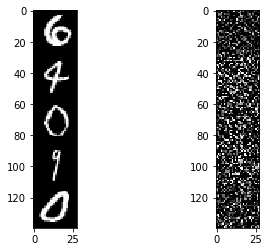

Iteration 1000:


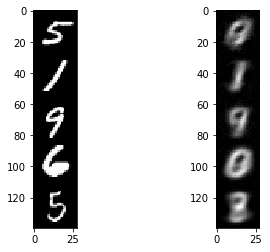

Iteration 2000:


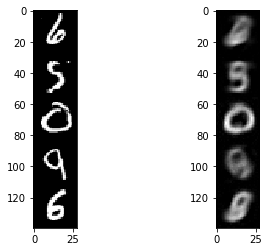

Iteration 3000:


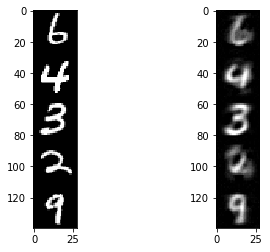

Iteration 4000:


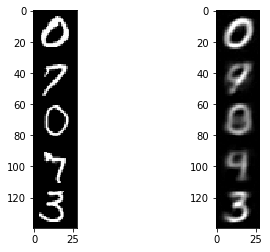

Iteration 5000:


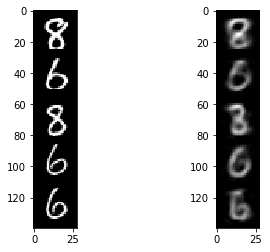

Iteration 6000:


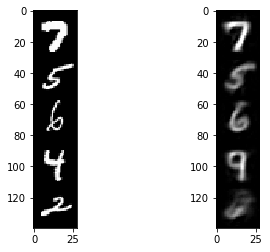

Iteration 7000:


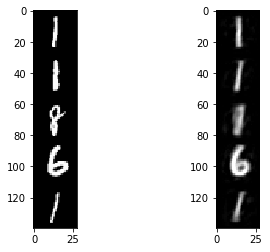

Iteration 8000:


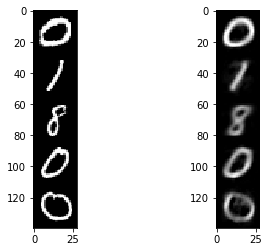

Iteration 9000:


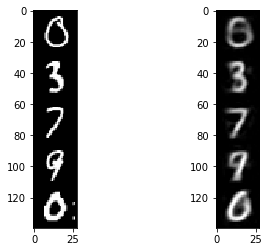

Iteration 10000:


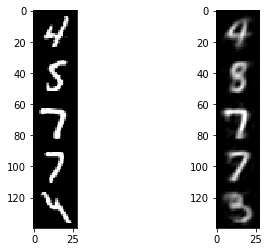

Iteration 11000:


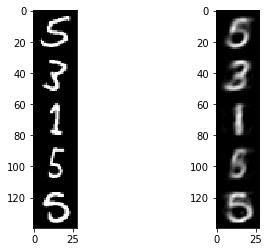

Iteration 12000:


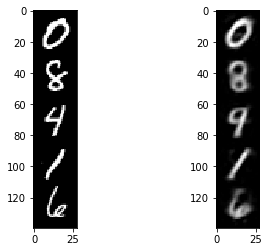

Iteration 13000:


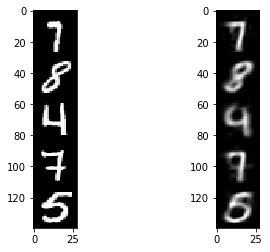

Iteration 14000:


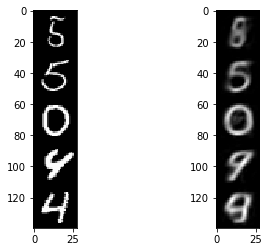

Iteration 15000:


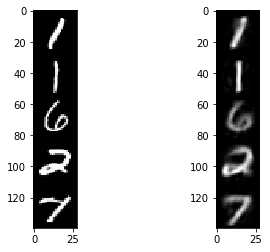

Iteration 16000:


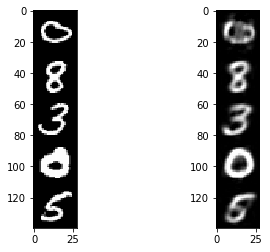

Iteration 17000:


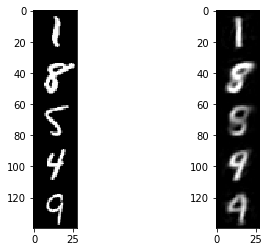

Iteration 18000:


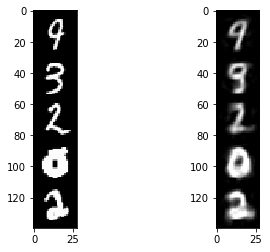

Iteration 19000:


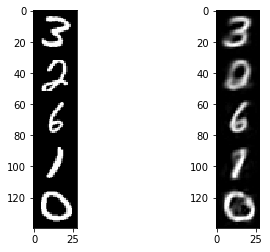

In [7]:
with tf.Session() as sess:    
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Train VAE model
    for i in range(20000):        
        batch = mnist.train.next_batch(100)
        sess.run(train_step_unlabeled, feed_dict={x: batch[0]}) # No labels
            
        # Visualize reconstructions every 1000 iterations
        if i % 1000 == 0:
            batch = mnist.validation.next_batch(5)
            reconstructions = sess.run(x_hat, feed_dict={x: batch[0]})
            print("Iteration {0}:".format(i))
            visualize_row(batch[0], reconstructions)